# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">How Scoring Works</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Vizual illustration</span> </center>


 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = "is_bad"

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(X.index, stratify=y, test_size=0.3, random_state=62)

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Business logic</span>

Here we try to undestand the feature trends.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class DataVisualizer:
    def __init__(self):
        pass

    @staticmethod
    def univariate_target_dependence(data, feature, target, ax=None, n_bins=10, plot=True):
        """
        Calculate partial dependence-like curve based on observed data.

        Parameters:
            data (pandas.DataFrame): The DataFrame containing the data.
            feature (str): The name of the feature for which to compute the partial dependence.
            target (str): The name of the target variable.
            ax (matplotlib.axes.Axes, optional): The axes on which to plot the graph.
            num_bins (int): The number of bins to use for binning the feature.
            plot (bool): If True, the univariate dependence plot will be created.

        Returns:
            pd.DataFrame: A DataFrame containing the binned feature values and the average observed target values.
        """
        sorted_data = data.sort_values(by=feature)
        binned_data = pd.qcut(sorted_data[feature], q=n_bins, labels=False, duplicates="drop")

        partial_dependence_data = sorted_data.groupby(binned_data)[target].mean().reset_index()
        partial_dependence_data.columns = ["bin", target]

        if plot:
            if ax is not None:
                ax.plot(
                    partial_dependence_data["bin"],
                    partial_dependence_data[target],
                    color="#a801ff",
                )
                ax.set_xlabel(feature)
                ax.set_ylabel(target)
                ax.set_title(feature)
            else:
                plt.plot(
                    partial_dependence_data["bin"],
                    partial_dependence_data[target],
                    color="#a801ff",
                )
                plt.xlabel(feature)
                plt.ylabel(target)
                plt.title(feature)
                plt.show()

        return partial_dependence_data

    @staticmethod
    def plot_2d_interactions(X, features, y, bins=20, plot_type="heatmap", title="", ax=None):
        if not isinstance(features, list) or len(features) != 2:
            raise ValueError("features must be a list containing exactly two feature names.")

        df = X.copy()
        # standardize the features from 0 to 1
        df[features[0]] = (df[features[0]] - df[features[0]].min()) / (
            df[features[0]].max() - df[features[0]].min()
        )
        df[features[1]] = (df[features[1]] - df[features[1]].min()) / (
            df[features[1]].max() - df[features[1]].min()
        )

        df[features[0]] = pd.cut(df[features[0]], bins=bins, labels=[str(i) for i in range(bins)])
        df[features[1]] = pd.cut(df[features[1]], bins=bins, labels=[str(i) for i in range(bins)])

        pivot_table = df.pivot_table(
            index=features[0], columns=features[1], values=y.name, aggfunc="mean"
        )

        if ax is None:
            ax = plt.gca()

        if plot_type == "heatmap":
            cax = ax.imshow(pivot_table, cmap="plasma", aspect="auto")
            plt.colorbar(cax, ax=ax, label=y.name)
        elif plot_type == "contour":
            CS = ax.contourf(
                pivot_table.columns,
                pivot_table.index,
                pivot_table.values,
                cmap="plasma",
            )
            plt.colorbar(CS, ax=ax, label=y.name)

        ax.set_title(title)
        ax.set_xlabel(features[1])
        ax.set_ylabel(features[0])

        # Adjust tick labels if necessary
        ax.set_xticks(range(len(pivot_table.columns)))
        ax.set_xticklabels(pivot_table.columns, rotation=45)
        ax.set_yticks(range(len(pivot_table.index)))
        ax.set_yticklabels(pivot_table.index)

        plt.tight_layout()

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Model training</span>

Imposing the business logic on the model.

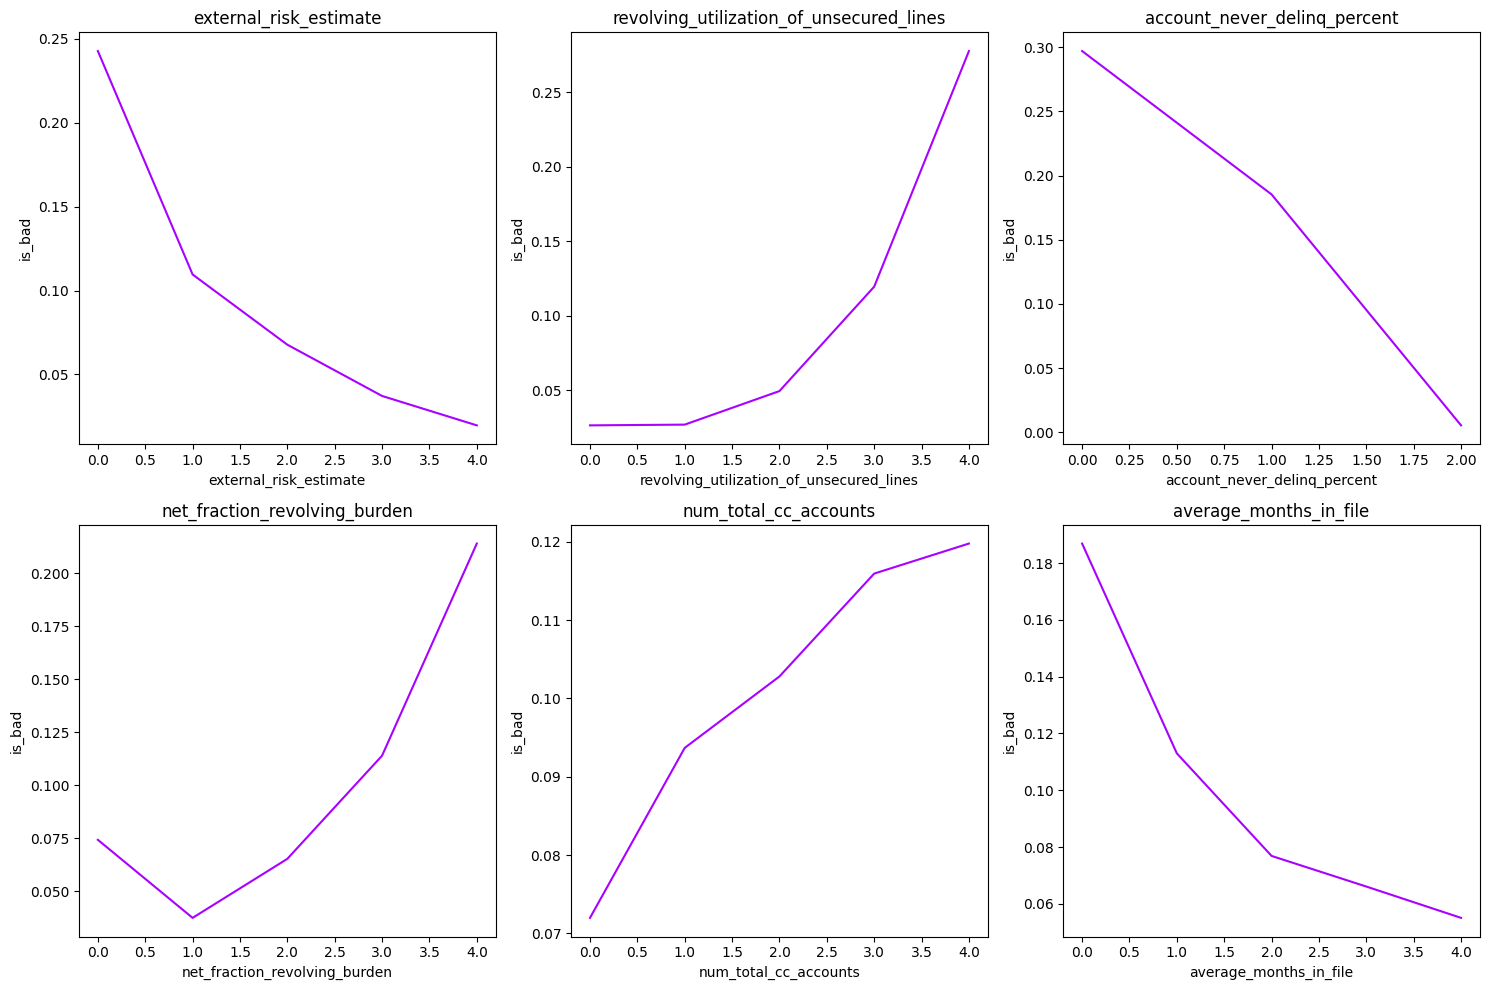

In [3]:
data_visualizer = DataVisualizer()
data = pd.concat([X, y], axis=1)  # Assume X and y are defined previously

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for idx, feature in enumerate(features):
    data_visualizer.univariate_target_dependence(
        data, feature, y.name, n_bins=5, ax=axs[idx], plot=True
    )

plt.tight_layout()
plt.show()

In [4]:
from optbinning import BinningProcess
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

binning_fit_params = {
    "external_risk_estimate": dict(
        monotonic_trend="descending",
        max_n_bins=10,
    ),
    "revolving_utilization_of_unsecured_lines": dict(
        monotonic_trend="ascending",
        max_n_bins=5,
    ),
    "account_never_delinq_percent": dict(
        monotonic_trend="descending",
        user_splits=[70, 90, 95],
        user_splits_fixed=[True, True, False],
    ),
    "net_fraction_revolving_burden": dict(
        monotonic_trend="ascending",
        max_n_bins=3,
    ),
    "num_total_cc_accounts": dict(monotonic_trend="ascending"),
    "average_months_in_file": dict(monotonic_trend="descending"),
}

model_pipeline = Pipeline(
    [
        (
            "binning_process",
            BinningProcess(
                binning_fit_params=binning_fit_params,
                variable_names=features,
            ),
        ),
        (
            "logistic_regression",
            LogisticRegression(fit_intercept=True, solver="newton-cg", C=0.001),
        ),
    ]
)

model_pipeline.fit(X.loc[ix_train], y.loc[ix_train])

y_pred = model_pipeline.predict_proba(X.loc[ix_test])[:, 1]

roc_auc_score(y.loc[ix_test], y_pred) * 2 - 1

(CVXPY) Apr 26 07:16:39 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 26 07:16:39 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


0.836641975308642

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Visualizing the Scoring Function</span>

Below we showcase the scoring function's working.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib

# Disable interactive mode
matplotlib.use("Agg")

# Initialize running totals outside the update function
total_samples = 0
accuracy = 0
total_defaults = 0
total_true_positives_1 = 0
total_non_defaults = 0
total_true_positives_0 = 0

df_with_samples = pd.DataFrame(
    {
        "label": [],
        "prediction": [],
    }
)

df_with_samples_2 = pd.DataFrame(
    {
        "label": [],
        "prediction": [],
    }
)


def _sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Sample the data in chunks
def sample_data(data, chunk_size=10):
    for i in range(0, data.shape[0], chunk_size):
        yield data.iloc[i : i + chunk_size], i + 1


# Update function for the animation
def update(args):  # sourcery skip: low-code-quality
    global total_samples, accuracy, total_defaults, total_true_positives_1, total_non_defaults, total_true_positives_0, df_with_samples, df_with_samples_2
    plt.rcParams["font.family"] = "Arial"

    frame, start_index = args
    plt.clf()  # Clear the figure to redraw
    current_sample = frame
    indices = np.arange(
        start_index, start_index + len(current_sample)
    )  # Indices for x-axis, adjusted for each batch

    probability_of_default = model_pipeline.predict_proba(current_sample)[:, 1]
    threshold = _sigmoid(model_pipeline.named_steps["logistic_regression"].intercept_).item()
    prediction = (probability_of_default >= threshold).astype(int)

    true_label = y.loc[current_sample.index]
    true_label_text = ["Bad" if p == 1 else "Good" for p in true_label]
    accuracy += (prediction == true_label).sum()
    total_samples += len(current_sample)

    current_defaults = (true_label == 1).sum()
    total_defaults += current_defaults
    current_true_positives_1 = ((prediction == 1) & (true_label == 1)).sum()
    total_true_positives_1 += current_true_positives_1
    recall_1 = total_true_positives_1 / total_defaults if total_defaults else 0

    current_non_defaults = (true_label == 0).sum()
    total_non_defaults += current_non_defaults
    current_true_positives_0 = ((prediction == 0) & (true_label == 0)).sum()
    total_true_positives_0 += current_true_positives_0
    recall_0 = total_true_positives_0 / total_non_defaults if total_non_defaults else 0

    balanced_accuracy = (recall_0 + recall_1) / 2

    # Compute thresholded AUC
    df_with_samples = pd.concat(
        [
            df_with_samples,
            pd.DataFrame({"label": true_label, "prediction": prediction}),
        ],
        axis=0,
    )

    if df_with_samples["label"].sum() == 0:
        auc_thresholded = 0
    else:
        auc_thresholded = roc_auc_score(
            df_with_samples["label"], df_with_samples["prediction"], average="micro"
        )

    # Compute non-thresholded AUC
    df_with_samples_2 = pd.concat(
        [
            df_with_samples_2,
            pd.DataFrame({"label": true_label, "prediction": probability_of_default}),
        ],
        axis=0,
    )

    if df_with_samples_2["label"].sum() == 0:
        auc = 0
    else:
        auc = roc_auc_score(df_with_samples_2["label"], df_with_samples_2["prediction"])

    bars = []  # List to collect bar containers

    # create a dictionary to rename variables for better comprehension
    rename_dict = {
        "external_risk_estimate": "External risk score",
        "revolving_utilization_of_unsecured_lines": "Credit card usage",
        "account_never_delinq_percent": "Not delinquent before",
        "net_fraction_revolving_burden": "Percent revolving",
        "num_total_cc_accounts": "Number of credit cards",
        "average_months_in_file": "Average months in file",
    }

    for i, feature in enumerate(features):
        feature_woe = -model_pipeline.named_steps["binning_process"].transform(
            current_sample, metric="woe"
        )[feature]
        bar = plt.bar(
            indices - start_index,
            feature_woe,
            alpha=0.9,
            color=colors[i],
            label=f"{rename_dict[feature]}",
            edgecolor="black",
            linewidth=0.3,
        )
        bars.append(bar)

    for i, p in enumerate(prediction):
        color = "#ff8787" if p == 1 else "#38d9a9"
        plt.gca().add_patch(
            plt.Rectangle(
                (i - 0.5, 0 if p == 1 else -3),
                1,
                3,
                color=color,
                alpha=0.18,
                linewidth=0,
            )
        )

    # Show for each bar the actual class label (0 or 1) based on the y value in true_label
    for i, label in enumerate(true_label_text):
        plt.text(
            i,
            0,
            label,
            ha="center",
            va="center",
            color="#368668" if label == "Good" else "#e64980",
            fontsize=10,
            # make bold text
            fontweight="bold",
            # set font to helvetica
            fontname="Helvetica",
            bbox=dict(
                facecolor="white",
                edgecolor="white",
                linewidth=0.5,
                boxstyle="round,pad=0.2",
            ),
        )

    # add a box with the number of misclassification
    plt.ylim(-3, 3)
    plt.xticks(
        ticks=np.arange(len(current_sample)), labels=indices
    )  # Set x-ticks to display actual sample IDs
    plt.axhline(y=0, linewidth=1.0, color="black")

    # # add a box with accuracy score and text Accuracy somewhere below the true_label_text
    plt.text(
        9.8,
        1.8,
        (
            f'Prediction (Class)\n'
            f'-\n'
            f'TPR: {recall_0:.0%}\n'
            f'TNR: {recall_1:.0%}\n'
            f'bACC: {balanced_accuracy:.0%}\n'
            f'AUC: {auc_thresholded:.0%}\n'
            f'-\n'
            f'Probability (PD) \n'
            f'-\n'
            f'Gini score: {auc*2-1:.0%}\n'
        ),
        fontsize=9,
        ha="left",
        va="center",
        fontweight="bold",
        fontname="Virgil GS",
        color="#228be6",
    )

    # add a small text box with a footnote
    fig.text(
        0.13,
        0.01,
        (
            f'Note: Prediction (Class) is based on {threshold:.2f} threshold. '
            f'TPR - True Positive Rate. TNR - True Negative Rate. bACC - Balanced Accuracy. '
            f'AUC - Area Under the Curve.'
        ),
        fontsize=8,
        color="gray",
        fontname="Arial",
    )
    # make tick line length to 0
    plt.tick_params(axis="x", length=0)
    plt.tick_params(axis="y", length=0)

    plt.title(
        "Loan Application Scoring",
        fontsize=17,
        y=1.06,
        fontname="Virgil GS",
        loc="left",
    )
    plt.xlabel("Application ID")
    plt.ylabel(
        (f"Weight of Evidence\n" f"in Favor of Default (Bad)"),
    )

    # Disable spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.legend(
        loc="lower center",
        bbox_to_anchor=(0.65, 1.03),
        fancybox=True,
        shadow=False,
        ncol=3,
        fontsize=9,
        frameon=False,
    )

    return bars


# Main setup for the animation
fig, ax = plt.subplots(figsize=(11, 6), dpi=200)
plt.rcParams["font.family"] = "Arial"
colors = plt.cm.Set3(np.linspace(0, 1, len(features)))  # Generate colors for each feature

# Create a generator for the data chunks
data_gen = sample_data(X.loc[ix_test][:1000])
total_chunks = (X.loc[ix_test].shape[0] + 9) // 10  # Calculate total number of chunks

ani = FuncAnimation(fig, update, frames=data_gen, repeat=True, save_count=total_chunks)  # type: ignore

# Save the animation as a GIF using the Pillow writer
ani.save("animation_2_fps.gif", writer=PillowWriter(fps=2))  # type: ignore

plt.show()

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_63151/1841443393.py:221: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
